In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

Using TensorFlow backend.


In [2]:
np.random.seed(1120)

In [3]:
data = pd.read_csv('./data/AT.dat', delimiter="\t",
                   skiprows=[0], names=["k","r","x","A[k,r,x]"])
print(data.head())
data = data.to_numpy()

# Use first 8,056 points as training/validation and rest as test set.
train_data = data[0:8056]
test_data = data[8056:]

       k         r         x  A[k,r,x]
0  0.001  0.010817 -0.973907  1.009217
1  0.001  0.010817 -0.679410  1.009143
2  0.001  0.010817 -0.148874  1.009077
3  0.001  0.010817  0.148874  1.009077
4  0.001  0.010817  0.679410  1.009142


### Implementation
Now, we have a fair understanding of what GA is and how it works. Next, let’s get to coding.

We will use wind power forecast data, which is available at the following link. It consists of normalized (between zero and one) wind power measurements from seven wind farms. To keep things simple, we will use first wind farm data (column named wp1) but I encourage the reader to experiment and extend the code to forecast energy for all seven, wind farms.

Let’s import required packages, load the dataset and define two helper functions. The first method prepare_dataset will segment the data into chunks to create X, Y pair for model training. The X will the wind power values from the past (e.g. 1 to t-1) and Y will be future value at time t. The second method train_evaluate perform three things, 1) decoding GA solution to get window size and number of units. 2) Prepare the dataset using window size found by GA and divide into train and validation set, and 3) train LSTM model, calculate RMSE on validation set and return it as a fitness score of the current GA solution.

In [4]:
data[:,1].shape
data[:,0:3].shape

(8556, 3)

In [5]:
np.zeros(11)[6:11]

array([0., 0., 0., 0., 0.])

In [36]:
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:3]
    Y = data[:,3]  
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    deep_size_bits = BitArray(ga_individual_solution[0:3])
    num_units_bits = BitArray(ga_individual_solution[3:8])
    learning_rate_bits = BitArray(ga_individual_solution[8:12])
    batch_size_bits = BitArray(ga_individual_solution[12:14])
    epochs_bits = BitArray(ga_individual_solution[14:])
    
    deep_size = deep_size_bits.uint +2
    num_units = num_units_bits.uint +1
    learning_rate = (learning_rate_bits.uint+1)*10**(-4)
    batch_size = 2**(batch_size_bits.uint +1)
    epochs = (epochs_bits.uint +1)*50
    
    print('\nDeep Size: ', deep_size, ', Num of Units: ', num_units, ', Learning rate: ', learning_rate)
    print('Batch Size: ', batch_size, ", Num of Epochs: ", epochs)
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    model = keras.Sequential()
    model.add(keras.Input(shape=(3,)))
    model.add(layers.Dense(num_units, input_shape=(3,)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    
    for i in range(deep_size):        
        model.add(layers.Dense(num_units, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer,loss='mean_squared_error')
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=1e-5,
                                   patience=3,
                                   restore_best_weights=True)]
    model.fit(X_train, y_train, epochs=epochs, callbacks=callbacks, batch_size=batch_size, shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

A continuación, use la paquetería DEAP para definir las cosas para ejecutar GA. Usaremos una representación binaria para la solución de longitud diez. Se inicializará aleatoriamente utilizando la distribución de Bernoulli. Del mismo modo, se utiliza el crossover ordenado, la mutación aleatoria y la selección de la rueda de la ruleta. Los valores del parámetro GA se inicializan arbitrariamente; Te sugerimos que juegues con diferentes configuraciones.



In [37]:
population_size = 4
num_generations = 3
gene_length = 15

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
                        ngen = num_generations, verbose = True)

C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Joshu\.conda\envs\tensorflow\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Deep Size:  5 , Num of Units:  3 , Learning rate:  0.0016
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples
Epoch 1/50
6444/6444 [==============================] - 5s 738us/sample - loss: 0.6220
Epoch 2/50
6444/6444 [==============================] - 2s 328us/sample - loss: 0.1213
Epoch 3/50
6444/6444 [==============================] - 2s 278us/sample - loss: 0.0143
Epoch 4/50
6444/6444 [==============================] - 2s 289us/sample - loss: 0.0026
Epoch 5/50
6444/6444 [==============================] - 2s 323us/sample - loss: 0.0020
Epoch 6/50
6444/6444 [==============================] - 2s 288us/sample - loss: 0.0020
Epoch 7/50
6444/6444 [==============================] - 2s 274us/sample - loss: 0.0020
Epoch 8/50
6444/6444 [==============================] - 2s 275us/sample - loss: 0.0020
Epoch 9/50
6444/6444 [==============================] - 2s 277us/sample - loss: 0.0020
Epoch 10/50
6444/6444 [==============================] - 2s 272us/sample - loss: 0.0020
Epoch 11/50

6444/6444 [==============================] - 2s 293us/sample - loss: 0.0020
Epoch 31/50
6444/6444 [==============================] - 2s 264us/sample - loss: 0.0020
Epoch 32/50
6444/6444 [==============================] - 2s 273us/sample - loss: 0.0020
Epoch 33/50
6444/6444 [==============================] - 2s 265us/sample - loss: 0.0020
Epoch 34/50
6444/6444 [==============================] - 2s 299us/sample - loss: 0.0020
Epoch 35/50
6444/6444 [==============================] - 2s 265us/sample - loss: 0.0020
Epoch 36/50
6444/6444 [==============================] - 2s 373us/sample - loss: 0.0020
Epoch 37/50
6444/6444 [==============================] - 3s 400us/sample - loss: 0.0020
Epoch 38/50
6444/6444 [==============================] - 2s 315us/sample - loss: 0.0020
Epoch 39/50
6444/6444 [==============================] - 2s 316us/sample - loss: 0.0020
Epoch 40/50
6444/6444 [==============================] - 2s 279us/sample - loss: 0.0020
Epoch 41/50
6444/6444 [=====================

6444/6444 [==============================] - 3s 405us/sample - loss: 0.0025
Epoch 11/50
6444/6444 [==============================] - 2s 326us/sample - loss: 0.0021
Epoch 12/50
6444/6444 [==============================] - 2s 317us/sample - loss: 0.0020
Epoch 13/50
6444/6444 [==============================] - 2s 302us/sample - loss: 0.0020
Epoch 14/50
6444/6444 [==============================] - 2s 299us/sample - loss: 0.0020
Epoch 15/50
6444/6444 [==============================] - 2s 295us/sample - loss: 0.0020
Epoch 16/50
6444/6444 [==============================] - 2s 294us/sample - loss: 0.0020
Epoch 17/50
6444/6444 [==============================] - 2s 303us/sample - loss: 0.0020
Epoch 18/50
6444/6444 [==============================] - 2s 306us/sample - loss: 0.0020
Epoch 19/50
6444/6444 [==============================] - 2s 302us/sample - loss: 0.0020
Epoch 20/50
6444/6444 [==============================] - 2s 328us/sample - loss: 0.0020
Epoch 21/50
6444/6444 [=====================

Epoch 40/50
6444/6444 [==============================] - 2s 292us/sample - loss: 0.0020
Epoch 41/50
6444/6444 [==============================] - 2s 330us/sample - loss: 0.0020
Epoch 42/50
6444/6444 [==============================] - 2s 299us/sample - loss: 0.0020
Epoch 43/50
6444/6444 [==============================] - 2s 311us/sample - loss: 0.0020
Epoch 44/50
6444/6444 [==============================] - 2s 336us/sample - loss: 0.0020
Epoch 45/50
6444/6444 [==============================] - 2s 338us/sample - loss: 0.0020
Epoch 46/50
6444/6444 [==============================] - 2s 351us/sample - loss: 0.0020
Epoch 47/50
6444/6444 [==============================] - 2s 343us/sample - loss: 0.0020
Epoch 48/50
6444/6444 [==============================] - 2s 326us/sample - loss: 0.0020
Epoch 49/50
6444/6444 [==============================] - 2s 341us/sample - loss: 0.0020
Epoch 50/50
6444/6444 [==============================] - 2s 319us/sample - loss: 0.0020
Validation RMSE:  0.044763141592

Epoch 19/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 5.6650e-04
Epoch 20/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 5.5822e-04
Epoch 21/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.1846e-04
Epoch 22/100
6444/6444 [==============================] - 6s 994us/sample - loss: 5.0398e-04
Epoch 23/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0053
Epoch 24/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.9040e-04
Epoch 25/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.0770e-04
Epoch 26/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.2800e-04
Epoch 27/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 6.4486e-04
Epoch 28/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 6.3760e-04
Epoch 29/100
6444/6444 [==============================] - 10s 2ms/sample - loss: 6.3824e-04


6444/6444 [==============================] - 7s 1ms/sample - loss: 5.1167e-04
Epoch 49/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.0348e-04
Epoch 50/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.6487e-04
Epoch 51/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.4492e-04
Epoch 52/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 6.4094e-04
Epoch 53/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 4.9359e-04
Epoch 54/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 4.3043e-04
Epoch 55/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.3250e-04
Epoch 56/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.6650e-04
Epoch 57/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 3.0568e-04
Epoch 58/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 3.2158e-04
Epoch 59/100

6444/6444 [==============================] - 7s 1ms/sample - loss: 2.6328e-04
Epoch 78/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5629e-04
Epoch 79/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5238e-04
Epoch 80/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.6960e-04
Epoch 81/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.9701e-04
Epoch 82/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.5610e-04
Epoch 83/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.4465e-04
Epoch 84/100
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.4987e-04
Epoch 85/100
6444/6444 [==============================] - 8s 1ms/sample - loss: 2.3556e-04
Epoch 86/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.3410e-04
Epoch 87/100
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.2239e-04
Epoch 88/100

Epoch 6/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0087
Epoch 7/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0030
Epoch 8/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0018
Epoch 9/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 9.4103e-04
Epoch 10/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.6865e-04
Epoch 11/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 9.0794e-04
Epoch 12/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.5792e-04
Epoch 13/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0010
Epoch 14/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 7.9581e-04
Epoch 15/50
6444/6444 [==============================] - 8s 1ms/sample - loss: 6.0737e-04
Epoch 16/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 5.6084e-04
Epoch 17/50
6444/6444 [=======

6444/6444 [==============================] - 7s 1ms/sample - loss: 3.5752e-04
Epoch 36/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1997e-04
Epoch 37/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.0727e-04
Epoch 38/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.9749e-04
Epoch 39/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.0453e-04
Epoch 40/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8431e-04
Epoch 41/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1757e-04
Epoch 42/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.5132e-04
Epoch 43/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.8205e-04
Epoch 44/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 3.1341e-04
Epoch 45/50
6444/6444 [==============================] - 9s 1ms/sample - loss: 2.8505e-04
Epoch 46/50
6444/6444 

6444/6444 [==============================] - 2s 323us/sample - loss: 0.0012
Epoch 15/50
6444/6444 [==============================] - 2s 294us/sample - loss: 0.0012
Epoch 16/50
6444/6444 [==============================] - 2s 295us/sample - loss: 0.0011
Epoch 17/50
6444/6444 [==============================] - 2s 298us/sample - loss: 0.0012
Epoch 18/50
6444/6444 [==============================] - 2s 298us/sample - loss: 0.0011
Epoch 19/50
6444/6444 [==============================] - 2s 304us/sample - loss: 0.0011
Epoch 20/50
6444/6444 [==============================] - 2s 311us/sample - loss: 9.9930e-04
Epoch 21/50
6444/6444 [==============================] - 2s 306us/sample - loss: 9.6615e-04
Epoch 22/50
6444/6444 [==============================] - 2s 326us/sample - loss: 8.8800e-04
Epoch 23/50
6444/6444 [==============================] - 2s 304us/sample - loss: 8.4382e-04
Epoch 24/50
6444/6444 [==============================] - 2s 316us/sample - loss: 8.4405e-04
Epoch 25/50
6444/6444 [=

Epoch 44/50
6444/6444 [==============================] - 2s 282us/sample - loss: 0.0014
Epoch 45/50
6444/6444 [==============================] - 2s 284us/sample - loss: 0.0014
Epoch 46/50
6444/6444 [==============================] - 2s 279us/sample - loss: 0.0014
Epoch 47/50
6444/6444 [==============================] - 2s 281us/sample - loss: 0.0014
Epoch 48/50
6444/6444 [==============================] - 2s 281us/sample - loss: 0.0014
Epoch 49/50
6444/6444 [==============================] - 2s 281us/sample - loss: 0.0014
Epoch 50/50
6444/6444 [==============================] - 2s 279us/sample - loss: 0.0014
Validation RMSE:  0.037739167062397334 


Deep Size:  5 , Num of Units:  3 , Learning rate:  0.0016
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples
Epoch 1/50
6444/6444 [==============================] - 6s 918us/sample - loss: 0.7384
Epoch 2/50
6444/6444 [==============================] - 2s 342us/sample - loss: 0.1366
Epoch 3/50
6444/6444 [=============================

6444/6444 [==============================] - 2s 320us/sample - loss: 0.0020
Epoch 24/50
6444/6444 [==============================] - 2s 286us/sample - loss: 0.0020
Epoch 25/50
6444/6444 [==============================] - 2s 281us/sample - loss: 0.0020
Epoch 26/50
6444/6444 [==============================] - 2s 281us/sample - loss: 0.0020
Epoch 27/50
6444/6444 [==============================] - 2s 319us/sample - loss: 0.0020
Epoch 28/50
6444/6444 [==============================] - 2s 317us/sample - loss: 0.0020
Epoch 29/50
6444/6444 [==============================] - 2s 332us/sample - loss: 0.0020
Epoch 30/50
6444/6444 [==============================] - 2s 318us/sample - loss: 0.0020
Epoch 31/50
6444/6444 [==============================] - 2s 326us/sample - loss: 0.0020
Epoch 32/50
6444/6444 [==============================] - 2s 292us/sample - loss: 0.0020
Epoch 33/50
6444/6444 [==============================] - 2s 296us/sample - loss: 0.0020
Epoch 34/50
6444/6444 [=====================

Epoch 3/50
6444/6444 [==============================] - 6s 945us/sample - loss: 4.4868
Epoch 4/50
6444/6444 [==============================] - 6s 956us/sample - loss: 22.1859
Epoch 5/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0727
Epoch 6/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.2506
Epoch 7/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.8256
Epoch 8/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 16.8264
Epoch 9/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.5428
Epoch 10/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0086
Epoch 11/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.0400
Epoch 12/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 2.5663
Epoch 13/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 1.5214
Epoch 14/50
6444/6444 [==============================] 

Epoch 33/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 4.2378
Epoch 34/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0030
Epoch 35/50
6444/6444 [==============================] - 6s 980us/sample - loss: 4.4890
Epoch 36/50
6444/6444 [==============================] - 6s 977us/sample - loss: 0.8897
Epoch 37/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0074
Epoch 38/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.3726
Epoch 39/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.4254
Epoch 40/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0128
Epoch 41/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0037
Epoch 42/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0287
Epoch 43/50
6444/6444 [==============================] - 7s 1ms/sample - loss: 0.0052
Epoch 44/50
6444/6444 [===========================

6444/6444 [==============================] - 3s 396us/sample - loss: 0.0016
Epoch 13/50
6444/6444 [==============================] - 2s 323us/sample - loss: 0.0016
Epoch 14/50
6444/6444 [==============================] - 2s 350us/sample - loss: 0.0015
Epoch 15/50
6444/6444 [==============================] - 2s 374us/sample - loss: 0.0015
Epoch 16/50
6444/6444 [==============================] - 2s 297us/sample - loss: 0.0015
Epoch 17/50
6444/6444 [==============================] - 3s 503us/sample - loss: 0.0016
Epoch 18/50
6444/6444 [==============================] - 4s 569us/sample - loss: 0.0015
Epoch 19/50
6444/6444 [==============================] - 3s 482us/sample - loss: 0.0015
Epoch 20/50
6444/6444 [==============================] - 3s 527us/sample - loss: 0.0015
Epoch 21/50
6444/6444 [==============================] - 3s 460us/sample - loss: 0.0015
Epoch 22/50
6444/6444 [==============================] - 3s 495us/sample - loss: 0.0015
Epoch 23/50
6444/6444 [=====================

Epoch 42/50
6444/6444 [==============================] - 2s 335us/sample - loss: 6.1763e-04
Epoch 43/50
6444/6444 [==============================] - 2s 337us/sample - loss: 5.8566e-04
Epoch 44/50
6444/6444 [==============================] - 2s 338us/sample - loss: 5.7972e-04
Epoch 45/50
6444/6444 [==============================] - 2s 340us/sample - loss: 5.8689e-04
Epoch 46/50
6444/6444 [==============================] - 2s 350us/sample - loss: 5.7970e-04
Epoch 47/50
6444/6444 [==============================] - 2s 349us/sample - loss: 6.1392e-04
Epoch 48/50
6444/6444 [==============================] - 2s 346us/sample - loss: 5.8281e-04
Epoch 49/50
6444/6444 [==============================] - 2s 346us/sample - loss: 5.8847e-04
Epoch 50/50
6444/6444 [==============================] - 2s 363us/sample - loss: 5.8704e-04
Validation RMSE:  0.022868595569807686 


Deep Size:  5 , Num of Units:  1 , Learning rate:  0.0005
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples
Epoch 1/50
64

6444/6444 [==============================] - 2s 283us/sample - loss: 0.0020
Epoch 22/50
6444/6444 [==============================] - 2s 285us/sample - loss: 0.0020
Epoch 23/50
6444/6444 [==============================] - 2s 293us/sample - loss: 0.0020
Epoch 24/50
6444/6444 [==============================] - 2s 294us/sample - loss: 0.0020
Epoch 25/50
6444/6444 [==============================] - 2s 289us/sample - loss: 0.0020
Epoch 26/50
6444/6444 [==============================] - 2s 290us/sample - loss: 0.0020
Epoch 27/50
6444/6444 [==============================] - 2s 299us/sample - loss: 0.0020
Epoch 28/50
6444/6444 [==============================] - 2s 331us/sample - loss: 0.0020
Epoch 29/50
6444/6444 [==============================] - 2s 377us/sample - loss: 0.0020
Epoch 30/50
6444/6444 [==============================] - 3s 501us/sample - loss: 0.0020
Epoch 31/50
6444/6444 [==============================] - 3s 462us/sample - loss: 0.0020
Epoch 32/50
6444/6444 [=====================

Validation RMSE:  0.04476857584422956 

2  	3     

Deep Size:  5 , Num of Units:  1 , Learning rate:  0.0005
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples
Epoch 1/50
6444/6444 [==============================] - 6s 925us/sample - loss: 0.9359
Epoch 2/50
6444/6444 [==============================] - 2s 369us/sample - loss: 0.6151
Epoch 3/50
6444/6444 [==============================] - 2s 374us/sample - loss: 0.3842
Epoch 4/50
6444/6444 [==============================] - 2s 374us/sample - loss: 0.2251
Epoch 5/50
6444/6444 [==============================] - 2s 301us/sample - loss: 0.1217
Epoch 6/50
6444/6444 [==============================] - 2s 303us/sample - loss: 0.0596
Epoch 7/50
6444/6444 [==============================] - 2s 306us/sample - loss: 0.0261
Epoch 8/50
6444/6444 [==============================] - 2s 301us/sample - loss: 0.0105
Epoch 9/50
6444/6444 [==============================] - 2s 299us/sample - loss: 0.0044
Epoch 10/50
6444/6444 [=========================

6444/6444 [==============================] - 2s 306us/sample - loss: 0.0020
Epoch 31/50
6444/6444 [==============================] - 2s 300us/sample - loss: 0.0020
Epoch 32/50
6444/6444 [==============================] - 2s 291us/sample - loss: 0.0020
Epoch 33/50
6444/6444 [==============================] - 2s 291us/sample - loss: 0.0020
Epoch 34/50
6444/6444 [==============================] - 2s 296us/sample - loss: 0.0020
Epoch 35/50
6444/6444 [==============================] - 2s 307us/sample - loss: 0.0020
Epoch 36/50
6444/6444 [==============================] - 2s 297us/sample - loss: 0.0020
Epoch 37/50
6444/6444 [==============================] - 2s 315us/sample - loss: 0.0020
Epoch 38/50
6444/6444 [==============================] - 2s 308us/sample - loss: 0.0020
Epoch 39/50
6444/6444 [==============================] - 2s 311us/sample - loss: 0.0020
Epoch 40/50
6444/6444 [==============================] - 2s 297us/sample - loss: 0.0020
Epoch 41/50
6444/6444 [=====================

6444/6444 [==============================] - 3s 490us/sample - loss: 0.0044
Epoch 10/50
6444/6444 [==============================] - 2s 365us/sample - loss: 0.0025
Epoch 11/50
6444/6444 [==============================] - 3s 415us/sample - loss: 0.0021
Epoch 12/50
6444/6444 [==============================] - 3s 419us/sample - loss: 0.0020
Epoch 13/50
6444/6444 [==============================] - 3s 411us/sample - loss: 0.0020
Epoch 14/50
6444/6444 [==============================] - 2s 294us/sample - loss: 0.0020
Epoch 15/50
6444/6444 [==============================] - 2s 306us/sample - loss: 0.0020
Epoch 16/50
6444/6444 [==============================] - 2s 285us/sample - loss: 0.0020
Epoch 17/50
6444/6444 [==============================] - 2s 363us/sample - loss: 0.0020
Epoch 18/50
6444/6444 [==============================] - 2s 368us/sample - loss: 0.0020
Epoch 19/50
6444/6444 [==============================] - 2s 338us/sample - loss: 0.0020
Epoch 20/50
6444/6444 [=====================

6444/6444 [==============================] - 3s 425us/sample - loss: 0.0020
Epoch 40/50
6444/6444 [==============================] - 2s 383us/sample - loss: 0.0020
Epoch 41/50
6444/6444 [==============================] - 2s 337us/sample - loss: 0.0020
Epoch 42/50
6444/6444 [==============================] - 2s 331us/sample - loss: 0.0020
Epoch 43/50
6444/6444 [==============================] - 2s 330us/sample - loss: 0.0020
Epoch 44/50
6444/6444 [==============================] - 2s 323us/sample - loss: 0.0020
Epoch 45/50
6444/6444 [==============================] - 2s 341us/sample - loss: 0.0020
Epoch 46/50
6444/6444 [==============================] - 2s 338us/sample - loss: 0.0020
Epoch 47/50
6444/6444 [==============================] - 3s 389us/sample - loss: 0.0020
Epoch 48/50
6444/6444 [==============================] - 2s 358us/sample - loss: 0.0020
Epoch 49/50
6444/6444 [==============================] - 2s 344us/sample - loss: 0.0020
Epoch 50/50
6444/6444 [=====================

6444/6444 [==============================] - 2s 383us/sample - loss: 0.0020
Epoch 20/50
6444/6444 [==============================] - 2s 349us/sample - loss: 0.0020
Epoch 21/50
6444/6444 [==============================] - 2s 345us/sample - loss: 0.0020
Epoch 22/50
6444/6444 [==============================] - 2s 340us/sample - loss: 0.0020
Epoch 23/50
6444/6444 [==============================] - 2s 343us/sample - loss: 0.0020
Epoch 24/50
6444/6444 [==============================] - 2s 301us/sample - loss: 0.0020
Epoch 25/50
6444/6444 [==============================] - 2s 309us/sample - loss: 0.0020
Epoch 26/50
6444/6444 [==============================] - 2s 321us/sample - loss: 0.0020
Epoch 27/50
6444/6444 [==============================] - 2s 305us/sample - loss: 0.0020
Epoch 28/50
6444/6444 [==============================] - 2s 305us/sample - loss: 0.0020
Epoch 29/50
6444/6444 [==============================] - 2s 320us/sample - loss: 0.0020
Epoch 30/50
6444/6444 [=====================

Epoch 49/50
6444/6444 [==============================] - 2s 283us/sample - loss: 0.0020
Epoch 50/50
6444/6444 [==============================] - 2s 292us/sample - loss: 0.0020
Validation RMSE:  0.044815237391863556 


Deep Size:  9 , Num of Units:  3 , Learning rate:  0.0005
Batch Size:  16 , Num of Epochs:  50
Train on 6444 samples
Epoch 1/50
6444/6444 [==============================] - 6s 996us/sample - loss: 0.9359
Epoch 2/50
6444/6444 [==============================] - 2s 379us/sample - loss: 0.6152
Epoch 3/50
6444/6444 [==============================] - 2s 334us/sample - loss: 0.3843
Epoch 4/50
6444/6444 [==============================] - 2s 345us/sample - loss: 0.2253
Epoch 5/50
6444/6444 [==============================] - 2s 345us/sample - loss: 0.1218
Epoch 6/50
6444/6444 [==============================] - 3s 399us/sample - loss: 0.0597
Epoch 7/50
6444/6444 [==============================] - 3s 396us/sample - loss: 0.0262
Epoch 8/50
6444/6444 [==============================] - 

6444/6444 [==============================] - 2s 363us/sample - loss: 0.0020
Epoch 29/50
6444/6444 [==============================] - 2s 345us/sample - loss: 0.0020
Epoch 30/50
6444/6444 [==============================] - 2s 380us/sample - loss: 0.0020
Epoch 31/50
6444/6444 [==============================] - 3s 441us/sample - loss: 0.0020
Epoch 32/50
6444/6444 [==============================] - 4s 576us/sample - loss: 0.0020
Epoch 33/50
6444/6444 [==============================] - 3s 489us/sample - loss: 0.0020
Epoch 34/50
6444/6444 [==============================] - 4s 567us/sample - loss: 0.0020
Epoch 35/50
6444/6444 [==============================] - 3s 475us/sample - loss: 0.0020
Epoch 36/50
6444/6444 [==============================] - 3s 533us/sample - loss: 0.0020
Epoch 37/50
6444/6444 [==============================] - 3s 472us/sample - loss: 0.0020
Epoch 38/50
6444/6444 [==============================] - 3s 445us/sample - loss: 0.0020
Epoch 39/50
6444/6444 [=====================

La solución K mejor encontrada a través de GA se puede ver fácilmente usando tools.selBest(population,k = 1). Después, la configuración óptima se puede utilizar para entrenar en el conjunto de entrenamiento completo y probarlo en el conjunto de prueba de espera.

In [40]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_deep_size = None
best_num_units = None
best_learning_rate = None
best_batch_size = None
best_epochs = None

for bi in best_individuals:
    deep_size_bits = BitArray(bi[0:3])
    num_units_bits = BitArray(bi[3:8])
    learning_rate_bits = BitArray(bi[8:12])
    batch_size_bits = BitArray(bi[12:14])
    epochs_bits = BitArray(bi[14:])
    
    best_deep_size = deep_size_bits.uint +2
    best_num_units = num_units_bits.uint +1
    best_learning_rate = (learning_rate_bits.uint + 1)*10**(-4)
    best_batch_size= 2**(batch_size_bits.uint +1)
    best_epochs= (epochs_bits.uint +1)*50
    print('\nDeep Size: ', best_deep_size, ', Num of Units: ', best_num_units, ', Learning rate: ', best_learning_rate)
    print('Batch Size: ', best_batch_size, ", Num of Epochs: ", best_epochs)


Deep Size:  5 , Num of Units:  1 , Learning rate:  0.0005
Batch Size:  16 , Num of Epochs:  50


In [42]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set
X_train,y_train = prepare_dataset(train_data)
X_test, y_test = prepare_dataset(test_data)

model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(best_num_units, input_shape=(3,)))
#     x = LSTM(num_units, input_shape=(window_size,1))(inputs)

for i in range(best_deep_size):        
    model.add(layers.Dense(best_num_units, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

optimizer = keras.optimizers.Adam(learning_rate=best_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
#                                    min_delta=1e-4,
#                                    patience=3,
#                                    restore_best_weights=True)]
# model.fit(X_train, y_train, epochs=epochs, callbacks=callbacks, batch_size=best_batch_size, shuffle=True)
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, shuffle=True)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Train on 8056 samples
Epoch 1/50
8056/8056 [==============================] - 7s 885us/sample - loss: 0.8923
Epoch 2/50
8056/8056 [==============================] - 3s 371us/sample - loss: 0.5206
Epoch 3/50
8056/8056 [==============================] - 2s 288us/sample - loss: 0.2786
Epoch 4/50
8056/8056 [==============================] - 2s 275us/sample - loss: 0.1329
Epoch 5/50
8056/8056 [==============================] - 2s 278us/sample - loss: 0.0546
Epoch 6/50
8056/8056 [==============================] - 2s 275us/sample - loss: 0.0189
Epoch 7/50
8056/8056 [==============================] - 2s 292us/sample - loss: 0.0061
Epoch 8/50
8056/8056 [==============================] - 2s 284us/sample - loss: 0.0027
Epoch 9/50
8056/8056 [==============================] - 2s 277us/sample - loss: 0.0021
Epoch 10/50
8056/8056 [==============================] - 2s 279us/sample - loss: 0.0020
Epoch 11/50
8056/8056 [==============================] - 2s 281us/sample - loss: 0.0020
Epoch 12/50
8056/80

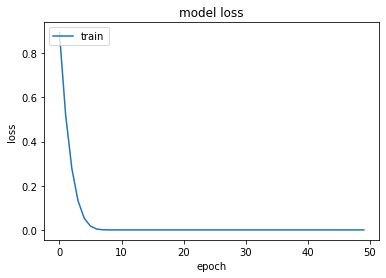

In [43]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()